In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import norm
import scipy.stats as st

import warnings

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

tqdm.pandas()
warnings.filterwarnings('ignore')

# Load & Pre-process Datasets

This procedures are essential to conduct our main analysis. 

## 1. Load `food` dataset

- It contains all 37.1M pairs of food pantry info and its BGs within 25 miles. We have shown this dataset from the jupyter file `prepare_data_statistics.ipynb`. 
- There are 34,475 food pantries and banks (FPs) in the dataset. 

In [2]:
food = pd.read_pickle('../data/fp_bg_pairs.pkl')

In [3]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37154567 entries, 0 to 37154566
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   address      object 
 1   ad_lat       float64
 2   ad_lon       float64
 3   ad_bg_fips   object 
 4   bg_fips      object 
 5   bg_lat       float64
 6   bg_lon       float64
 7   distance_mi  float64
dtypes: float64(5), object(3)
memory usage: 2.2+ GB


In [4]:
food.address.nunique()

34475

## 2. Load `bg` dataset 
- the original 2020 ADI dataset from UW Madison's Neighborhood Atlas.

- `bg_cont`: ADI dataset of BGs in the continental U.S -> a total of 239,780 BGs in 50 states and the DC.

In [5]:
bg = pd.read_csv('../data/US_2020_ADI_Census Block Group_v3.2.csv',
                dtype={'FIPS':str, 'ADI_NATRANK':str, 'ADI_STATERNK':str})
bg = bg[['FIPS', 'ADI_NATRANK', 'ADI_STATERNK']]
bg = bg.rename(columns={'FIPS':'bg_fips'})

In [6]:
bg_cont = bg.loc[(~bg.bg_fips.str.startswith('72')) # Puerto Rico
             & (~bg.bg_fips.str.startswith('78')) # Virgin Islands of the U.S.
            & (~bg.bg_fips.str.startswith('69')) # Northern Mariana Islands
            & (~bg.bg_fips.str.startswith('66')) # Guam
            & (~bg.bg_fips.str.startswith('60'))] # American Samoa

In [7]:
bg_cont.bg_fips.nunique()

239780

## 3. Find and merge the state/county info for each BG

- `find_sate_fips` retrieves the corresponding state information based on the first two digits of each BG's FIPS. 
- `us-state-fips.csv` contains all FIPS code of the 50 states and DC in the continental U.S.
- Note that the first two and five digits of each BG's FIPS indicate the BG's state and county, respectively. 

In [8]:
def find_state_fips(bg, state_data):
    
    st_fips = bg[:2]
    for i in range(len(state_data)):
        if state_data['st_fips'][i] == st_fips:            
            return state_data['st_abb'][i]

In [9]:
state_fips = pd.read_csv('../data/us-state-fips.csv',
                        dtype = {'stname':str, ' st':str, ' stusps':str})
state_fips = state_fips.rename(columns={'stname':'STATE', ' st':'st_fips', ' stusps':'st_abb'})
state_fips.st_abb = state_fips.st_abb.str.strip()
state_fips.st_fips = state_fips.st_fips.str.strip()

In [10]:
bg_cont['bg_state'] = bg_cont.progress_apply(lambda x:find_state_fips(x.bg_fips, state_fips), axis=1)
bg_cont['bg_county']  = bg_cont.progress_apply(lambda x:x.bg_fips[0:5], axis=1)

100%|███████████████████████████████| 239780/239780 [00:00<00:00, 343685.44it/s]


In [11]:
bg_cont

,bg_fips,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county
0,010010201001,73,5,AL,01001
1,010010201002,62,3,AL,01001
2,010010202001,83,7,AL,01001
3,010010202002,87,7,AL,01001
4,010010203001,73,5,AL,01001
...,...,...,...,...,...
239775,560459511001,65,8,WY,56045
239776,560459511002,49,6,WY,56045
239777,560459513001,85,10,WY,56045
239778,560459513002,70,9,WY,56045


## 4. Find each BG's rural status (based on RUCC 2013 Codes)
- `county_rurality`: the entire county-level dataset of RUCC 2013 codes from USDA ERS, where BGs in counties tagged with all subcategories within 'Metro' are considered as urban and all within 'Nonmetro' as rural. 

In [12]:
county_rurality = pd.read_csv('../data/ruralurbancodes2013.csv', 
                          dtype = {'FIPS':str})

county_rurality['RUCC_2013'] = county_rurality['RUCC_2013'].astype(str)
county_rurality.Description = county_rurality.Description.str.strip()

def decide_urban_degree(text):
    
    if text.startswith('Metro'):
        
        return 'Metro'
    
    elif text.startswith('Nonmetro'):
        return 'Nonmetro'
    
    else:
        return 'N/A'


county_rurality['status'] = county_rurality.apply(lambda x:decide_urban_degree(x.Description), axis=1)
county_rurality = county_rurality.rename(columns={'FIPS':'bg_county'})
county_rurality 

,bg_county,State,County_Name,Population_2010,RUCC_2013,Description,status
0,01001,AL,Autauga County,"54,571",2.0,"Metro - Counties in metro areas of 250,000 to ...",Metro
1,01003,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...,Metro
2,01005,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro
3,01007,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...,Metro
4,01009,AL,Blount County,"57,322",1.0,Metro - Counties in metro areas of 1 million p...,Metro
...,...,...,...,...,...,...,...
3229,72151,PR,Yabucoa Municipio,"37,941",1.0,Metro - Counties in metro areas of 1 million p...,Metro
3230,72153,PR,Yauco Municipio,"42,043",2.0,"Metro - Counties in metro areas of 250,000 to ...",Metro
3231,78010,VI,St. Croix Island,"50,601",5.0,"Nonmetro - Urban population of 20,000 or more,...",Nonmetro
3232,78020,VI,St. John Island,"4,170",7.0,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro


## 5. Merge `bg_cont` with the `county_rurality` information

- Results in a dataset of all block groups' FIPS code, their ADI, state/county, and urban/rural status. 

In [13]:
bg_cont = bg_cont.merge(county_rurality[['bg_county', 'status']].drop_duplicates(subset=['bg_county']), how='left', on='bg_county')

In [14]:
bg_cont

,bg_fips,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status
0,010010201001,73,5,AL,01001,Metro
1,010010201002,62,3,AL,01001,Metro
2,010010202001,83,7,AL,01001,Metro
3,010010202002,87,7,AL,01001,Metro
4,010010203001,73,5,AL,01001,Metro
...,...,...,...,...,...,...
239775,560459511001,65,8,WY,56045,Nonmetro
239776,560459511002,49,6,WY,56045,Nonmetro
239777,560459513001,85,10,WY,56045,Nonmetro
239778,560459513002,70,9,WY,56045,Nonmetro


Since our FP dataset was created in the year 2022, and there have been some updates for the following counties, we need to also include those counties' rurality info:

Shannon County, SD (FIPS code = 46113) was renamed Oglala Lakota County and assigned a new FIPS code (46102) effective in 2014.
Alaska has announced the split of Valdez-Cordova Borough (FIPS code = 02261) into two new census areas: Chugach (FIPS code = 02063) and Copper River (FIPS code = 02066). These changes will first appear in the 2020 ACS products.
Wade-Hampton Census Area, AK (FIPS code = 02270) was renamed Kusilvak Census Area, AK and assigned a new FIPS code (02158) effective in 2014.

In [15]:
print(bg_cont[bg_cont['status'].isna()])
bg_cont.loc[bg_cont['status'].isna(), 'status'] = 'Nonmetro'

             bg_fips ADI_NATRANK ADI_STATERNK bg_state bg_county status
4142    020630002001          29            3       AK     02063    NaN
4143    020630002002          24            2       AK     02063    NaN
4144    020630003001          39            5       AK     02063    NaN
4145    020630003002          91           10       AK     02063    NaN
4146    020630003003          60            9       AK     02063    NaN
4147    020630003004          36            5       AK     02063    NaN
4148    020630003005          82           10       AK     02063    NaN
4149    020660001001          45            7       AK     02066    NaN
4150    020660001002          48            7       AK     02066    NaN
4301    021580001001          89           10       AK     02158    NaN
4302    021580001002          98           10       AK     02158    NaN
4303    021580001003          98           10       AK     02158    NaN
4304    021580001004         QDI          QDI       AK     02158

In [16]:
print(bg_cont['bg_county'].nunique())

3143


All BGs in our dataset  `food` that are identified as having at least a FP < 25 miles 

- 238,536 BGs: have FPs ≤ 25 miles
- 1,244 BGs: have no FPs ≤ 25 miles

In [17]:
bg_with_fp = food.bg_fips.unique()
len(bg_with_fp)

238536

Now, it's time to pre-process the accessibility dataset. 

## 7. Pre-process the accessibility dataset

`bg_access`: the dataset that we created from `compute_travel_time.ipynb` file, which consists of all information about each BG and its nearest FP, along with distance/travel time/driving distance between them, ADI and state info. 

In [34]:
# dd = pd.read_csv('../data/bg_transit_adi.csv', dtype={'bg_fips':str})
# dd = dd[['bg_fips', 'address', 'distance_mi', 'transit_time', 'walking_time']]

# ff = pd.read_csv('../data/bg_not_included.csv', dtype={'bg_fips':str})
# ff = ff[['bg_fips', 'address', 'distance_mi', 'transit_time', 'walking_time']]

# pd.concat([dd, ff], ignore_index=True).sort_values(by='bg_fips').to_csv('../data/bg_pantry_travel_time_updated.csv', index=False)

In [18]:
bg_access = pd.read_csv('../data/bg_pantry_travel_time_updated.csv', dtype={'bg_fips':str})

In [19]:
bg_access.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238536 entries, 0 to 238535
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bg_fips              238536 non-null  object 
 1   address              238536 non-null  object 
 2   distance_mi          238536 non-null  float64
 3   transit_time         166589 non-null  float64
 4   walking_time         237842 non-null  float64
 5   driving_distance_km  238536 non-null  object 
dtypes: float64(3), object(3)
memory usage: 10.9+ MB


Merge the accessibility dataset with `bg_cont` that contains each BG's ADI, state/county, and rurality information 

In [20]:
bg_access = bg_access.merge(bg_cont.drop_duplicates(subset=['bg_fips']), how='left', on='bg_fips')

In [21]:
bg_access

,bg_fips,address,distance_mi,transit_time,walking_time,driving_distance_km,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,20.08,20.08,1.689,73,5,AL,01001,Metro
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,37.30,37.30,3.262,62,3,AL,01001,Metro
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,20.33,20.33,1.784,83,7,AL,01001,Metro
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,8.40,8.40,0.667,87,7,AL,01001,Metro
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,42.63,42.63,3.63,73,5,AL,01001,Metro
...,...,...,...,...,...,...,...,...,...,...,...
238531,560430003012,"620 Big Horn Ave, Worland, WY 82401",0.529835,14.47,14.47,1.187,76,10,WY,56043,Nonmetro
238532,560430003013,"620 Big Horn Ave, Worland, WY 82401",0.308140,7.37,7.37,0.666,68,9,WY,56043,Nonmetro
238533,560430003021,"620 Big Horn Ave, Worland, WY 82401",0.966369,27.67,27.67,2.305,62,8,WY,56043,Nonmetro
238534,560430003022,"620 Big Horn Ave, Worland, WY 82401",1.192660,29.00,29.00,2.411,58,7,WY,56043,Nonmetro


In [22]:
bg_access

,bg_fips,address,distance_mi,transit_time,walking_time,driving_distance_km,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,20.08,20.08,1.689,73,5,AL,01001,Metro
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,37.30,37.30,3.262,62,3,AL,01001,Metro
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,20.33,20.33,1.784,83,7,AL,01001,Metro
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,8.40,8.40,0.667,87,7,AL,01001,Metro
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,42.63,42.63,3.63,73,5,AL,01001,Metro
...,...,...,...,...,...,...,...,...,...,...,...
238531,560430003012,"620 Big Horn Ave, Worland, WY 82401",0.529835,14.47,14.47,1.187,76,10,WY,56043,Nonmetro
238532,560430003013,"620 Big Horn Ave, Worland, WY 82401",0.308140,7.37,7.37,0.666,68,9,WY,56043,Nonmetro
238533,560430003021,"620 Big Horn Ave, Worland, WY 82401",0.966369,27.67,27.67,2.305,62,8,WY,56043,Nonmetro
238534,560430003022,"620 Big Horn Ave, Worland, WY 82401",1.192660,29.00,29.00,2.411,58,7,WY,56043,Nonmetro


Because `bg_access` contains only 238,536 BGs that do have at least one FP ≤ 25 miles so that we can compute travel time, for the entire analysis, we update `bg_access` by also including the other BGs that do not have FPs ≤ 25 miles.

In [23]:
bg_access = pd.concat([bg_access, bg_cont.loc[(~bg_cont.bg_fips.isin(bg_with_fp))]])

Now, we have accessibility information for all 239,780 BGs in the 50 states and the DC. 

In [24]:
bg_access

,bg_fips,address,distance_mi,transit_time,walking_time,driving_distance_km,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,20.08,20.08,1.689,73,5,AL,01001,Metro
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,37.30,37.30,3.262,62,3,AL,01001,Metro
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,20.33,20.33,1.784,83,7,AL,01001,Metro
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,8.40,8.40,0.667,87,7,AL,01001,Metro
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,42.63,42.63,3.63,73,5,AL,01001,Metro
...,...,...,...,...,...,...,...,...,...,...,...
239768,560430002003,NaN,NaN,NaN,NaN,NaN,47,5,WY,56043,Nonmetro
239776,560459511002,NaN,NaN,NaN,NaN,NaN,49,6,WY,56045,Nonmetro
239777,560459513001,NaN,NaN,NaN,NaN,NaN,85,10,WY,56045,Nonmetro
239778,560459513002,NaN,NaN,NaN,NaN,NaN,70,9,WY,56045,Nonmetro


Based on our definition of accessibility, we compute shorter travel time to measure accessibility for urban areas, by the least travel time by transit or walking. This is stored in the `access` column. 

In [25]:
def shorter_travel(transit, walk):
    travel = 0
    if np.isnan(transit) == False:
        if np.isnan(walk) == False:
            if transit >= walk: # transit 0 walk 0
                travel = walk
            else:
                travel = transit
        else: # transit 0 walk x
            travel = transit
    else: #transit x
        if np.isnan(walk) == False: # transit x walk 0
            travel = walk
        else:
            travel = None # transit x walk x

    return travel

In [26]:
bg_access['access'] = bg_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|███████████████████████████████| 239780/239780 [00:02<00:00, 119888.87it/s]


In [27]:
def isnumber(x): # convert all ADI to its numeric format
    try:
        d = int(x)
        return d
    except:
        return None


bg_access['ADI_NATRANK'] = bg_access.progress_apply(lambda x:isnumber(x.ADI_NATRANK), axis=1)

100%|███████████████████████████████| 239780/239780 [00:00<00:00, 280555.06it/s]


In [28]:
bg_access

,bg_fips,address,distance_mi,transit_time,walking_time,driving_distance_km,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status,access
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,20.08,20.08,1.689,73.0,5,AL,01001,Metro,20.08
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,37.30,37.30,3.262,62.0,3,AL,01001,Metro,37.30
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,20.33,20.33,1.784,83.0,7,AL,01001,Metro,20.33
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,8.40,8.40,0.667,87.0,7,AL,01001,Metro,8.40
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,42.63,42.63,3.63,73.0,5,AL,01001,Metro,42.63
...,...,...,...,...,...,...,...,...,...,...,...,...
239768,560430002003,NaN,NaN,NaN,NaN,NaN,47.0,5,WY,56043,Nonmetro,NaN
239776,560459511002,NaN,NaN,NaN,NaN,NaN,49.0,6,WY,56045,Nonmetro,NaN
239777,560459513001,NaN,NaN,NaN,NaN,NaN,85.0,10,WY,56045,Nonmetro,NaN
239778,560459513002,NaN,NaN,NaN,NaN,NaN,70.0,9,WY,56045,Nonmetro,NaN


In [29]:
nan_address_rows = bg_access[bg_access['address'].isna()]
rest_metro = nan_address_rows[nan_address_rows['status'] == 'Metro']
rest_rural = nan_address_rows[nan_address_rows['status'] == 'Nonmetro']
print(rest_metro)
print(rest_rural)

             bg_fips address  distance_mi  transit_time  walking_time  \
4126    020200029001     NaN          NaN           NaN           NaN   
4127    020200029002     NaN          NaN           NaN           NaN   
4209    020900017001     NaN          NaN           NaN           NaN   
4213    020900019021     NaN          NaN           NaN           NaN   
4215    020900019023     NaN          NaN           NaN           NaN   
...              ...     ...          ...           ...           ...   
232738  530730101032     NaN          NaN           NaN           NaN   
239555  560210020011     NaN          NaN           NaN           NaN   
239557  560210020021     NaN          NaN           NaN           NaN   
239618  560250014013     NaN          NaN           NaN           NaN   
239630  560250018021     NaN          NaN           NaN           NaN   

       driving_distance_km  ADI_NATRANK ADI_STATERNK bg_state bg_county  \
4126                   NaN         13.0         

Considering that land areas are typically larger for BGs in rural areas than in urban areas (see land area analysis), for BGs that do not have FPs within 25 miles in rural areas we computed distance of FPs located within 50 miles. And there are 235 BGs that do not have any FPs ≤ 50 miles.

In [30]:
rest_driving_dist = pd.read_csv('../data/all_rural_rest_pairs_1056_fipstr.csv', dtype={'bg_fips':str})
print(rest_driving_dist[rest_driving_dist['address'].isna()])
df_rural_dist_rest = rest_rural.merge(rest_driving_dist[['bg_fips', 'driving_distance_km']], on='bg_fips', how='left', suffixes=('', '_new'))
df_rural_dist_rest['driving_distance_km'] = df_rural_dist_rest['driving_distance_km_new']
df_rural_dist_rest = df_rural_dist_rest.drop(columns = ['driving_distance_km_new'])


           bg_fips     bg_lat      bg_lon address  distance_mi  \
6     020130001001  54.746653 -164.070289     NaN          NaN   
7     020130001002  55.513902 -161.728860     NaN          NaN   
8     020130001003  55.095247 -160.027275     NaN          NaN   
9     020160001001  51.959447  178.338813     NaN          NaN   
10    020160002001  53.858423 -166.890178     NaN          NaN   
...            ...        ...         ...     ...          ...   
1006  560079680001  41.506147 -106.816855     NaN          NaN   
1007  560079680002  41.470860 -106.807075     NaN          NaN   
1009  560079680004  41.276570 -106.984925     NaN          NaN   
1011  560079681002  41.711325 -106.455987     NaN          NaN   
1019  560130004002  43.776714 -109.528830     NaN          NaN   

      driving_distance_km  
6                     NaN  
7                     NaN  
8                     NaN  
9                     NaN  
10                    NaN  
...                   ...  
1006       

In [31]:
not_nan_address_rows = bg_access[~bg_access['address'].isna()]
bg_metro = not_nan_address_rows[not_nan_address_rows['status'] == 'Metro']
bg_rural = not_nan_address_rows[not_nan_address_rows['status'] == 'Nonmetro']
df_rural_dist = pd.concat([bg_rural, df_rural_dist_rest], ignore_index=True)
print(df_rural_dist)
df_metro = pd.concat([bg_metro, rest_metro], ignore_index=True)
print(df_metro)

            bg_fips                                   address  distance_mi  \
0      010059501001      111 Jackson Street Eufaula, AL 36072     4.921180   
1      010059501002      111 Jackson Street Eufaula, AL 36072    11.686954   
2      010059502001  11 East College Street Clayton, AL 36016     5.718206   
3      010059502002             276 AL-239, Clayton, AL 36016     4.960451   
4      010059502003  11 East College Street Clayton, AL 36016     3.365542   
...             ...                                       ...          ...   
41008  560430002003                                       NaN          NaN   
41009  560459511002                                       NaN          NaN   
41010  560459513001                                       NaN          NaN   
41011  560459513002                                       NaN          NaN   
41012  560459513003                                       NaN          NaN   

       transit_time  walking_time driving_distance_km  ADI_NATR

Here's the definitions of "High, Medium, or Low accessibility" between a BG and its nearest food pantry by driving distance. 
<div align="center">

| Driving distance | **High/Medium/Low?*|
|------------------|--------------------|
| <= 10            | High               |
| <= 20 and >10    | Medium             |
| > 20             | Low                |
</div>

In [32]:
df_rural_dist['access'] = df_rural_dist['driving_distance_km'].apply(lambda x: float(x)*0.621371 if x != 'None' else np.nan)

def categorize_access(miles):
    if miles <= 10:
        return 'High access'
    elif 10 < miles <= 20:
        return 'Medium access'
    elif miles > 20 or np.isnan(miles):
        return 'Low access'

df_rural_dist['category'] = df_rural_dist['access'].apply(categorize_access)

In [33]:
df_rural_dist.to_csv('../data/df_rural_distance.csv',index=False)

-------------------------------------------------------------------------------------------

# Table 1 (b)

## (1) Characteristics of BGs in rural areas

In [34]:
print('1. total # BGs in rural area): ', len(df_rural_dist))
print('--------------------------------------------')

print('2. Statistics of national ADI percentiles')
print('how many valid BGs: ', len(df_rural_dist.loc[~df_rural_dist.ADI_NATRANK.isna()]))
print('Mean: ', np.mean(df_rural_dist.ADI_NATRANK))
print('SD: ', np.std(df_rural_dist.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((df_rural_dist.ADI_NATRANK)), 
                                   scale=st.sem((df_rural_dist.ADI_NATRANK), nan_policy='omit')))
print('--------------------------------------------')

print('3. Statistic of travel miles (accessibility)')
print('Mean: ', np.mean(df_rural_dist.access))
print('SD: ', np.std(df_rural_dist.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((df_rural_dist.access)), 
                                   scale=st.sem((df_rural_dist.access), nan_policy='omit')))

print('--------------------------------------------')

1. total # BGs in rural area):  41013
--------------------------------------------
2. Statistics of national ADI percentiles
how many valid BGs:  40046
Mean:  71.25290915447236
SD:  20.580270497209224
95% CI:  (71.05133956066476, 71.45447874827997)
--------------------------------------------
3. Statistic of travel miles (accessibility)
Mean:  9.47856830755323
SD:  31.025412549635206
95% CI:  (9.176694322019435, 9.780442293087026)
--------------------------------------------


## (2) Level of Accessibility

In [35]:
rural_high_access = df_rural_dist.loc[df_rural_dist['category']=='High access']
rural_high_access

,bg_fips,address,distance_mi,transit_time,walking_time,driving_distance_km,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status,access,category
0,010059501001,"111 Jackson Street Eufaula, AL 36072",4.921180,NaN,126.470000,10.197,76.0,5,AL,01005,Nonmetro,6.336120,High access
2,010059502001,"11 East College Street Clayton, AL 36016",5.718206,NaN,117.570000,9.295,95.0,9,AL,01005,Nonmetro,5.775643,High access
3,010059502002,"276 AL-239, Clayton, AL 36016",4.960451,NaN,147.216667,13.644,NaN,GQ,AL,01005,Nonmetro,8.477986,High access
4,010059502003,"11 East College Street Clayton, AL 36016",3.365542,NaN,105.870000,8.608,90.0,8,AL,01005,Nonmetro,5.348762,High access
10,010059505001,"9 Cheneyhatchee Drive Eufaula, AL 36027",7.276790,NaN,186.700000,15.381,69.0,4,AL,01005,Nonmetro,9.557307,High access
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39951,560430003011,"620 Big Horn Ave, Worland, WY 82401",0.410248,9.72,9.720000,0.785,71.0,9,WY,56043,Nonmetro,0.487776,High access
39952,560430003012,"620 Big Horn Ave, Worland, WY 82401",0.529835,14.47,14.470000,1.187,76.0,10,WY,56043,Nonmetro,0.737567,High access
39953,560430003013,"620 Big Horn Ave, Worland, WY 82401",0.308140,7.37,7.370000,0.666,68.0,9,WY,56043,Nonmetro,0.413833,High access
39954,560430003021,"620 Big Horn Ave, Worland, WY 82401",0.966369,27.67,27.670000,2.305,62.0,8,WY,56043,Nonmetro,1.432260,High access


### `high access` in Table 1 (b)

In [36]:
print('1. total # BGs in high access(rural): ', len(rural_high_access))
print('total % BGs in high access(rural): ', len(rural_high_access)/len(df_rural_dist))
print('--------------------------------------------')

print('2. Statistics of national ADI percentiles')
print('how many valid BGs: ', len(rural_high_access.loc[~rural_high_access.ADI_NATRANK.isna()]))
print('Mean: ', np.mean(rural_high_access.ADI_NATRANK))
print('SD: ', np.std(rural_high_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((rural_high_access.ADI_NATRANK)), 
                                   scale=st.sem((rural_high_access.ADI_NATRANK), nan_policy='omit')))
print('--------------------------------------------')

print('3. Statistic of travel miles (accessibility)')
print('Mean: ', np.mean(rural_high_access.access))
print('SD: ', np.std(rural_high_access.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((rural_high_access.access)), 
                                   scale=st.sem((rural_high_access.access))))

print('--------------------------------------------')

1. total # BGs in high access(rural):  27953
total % BGs in high access(rural):  0.6815643820252115
--------------------------------------------
2. Statistics of national ADI percentiles
how many valid BGs:  27363
Mean:  71.08697876694806
SD:  20.539337344712205
95% CI:  (70.84361237711846, 71.33034515677767)
--------------------------------------------
3. Statistic of travel miles (accessibility)
Mean:  3.8110269256463707
SD:  2.848544689238531
95% CI:  (3.7776332146363147, 3.8444206366564266)
--------------------------------------------


### `medium access` in Table 1 (b)

In [37]:
rural_medium_access = df_rural_dist.loc[df_rural_dist['category']=='Medium access']
rural_medium_access

,bg_fips,address,distance_mi,transit_time,walking_time,driving_distance_km,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status,access,category
1,010059501002,"111 Jackson Street Eufaula, AL 36072",11.686954,NaN,272.920000,22.485,94.0,9,AL,01005,Nonmetro,13.971527,Medium access
5,010059503001,"276 AL-239, Clayton, AL 36016",7.311567,NaN,200.670000,16.732,84.0,7,AL,01005,Nonmetro,10.396780,Medium access
6,010059503002,"276 AL-239, Clayton, AL 36016",10.252364,NaN,245.380000,22.934,99.0,10,AL,01005,Nonmetro,14.250523,Medium access
7,010059504001,"3102 Highway 131 Clayton, AL 36016",8.513760,NaN,199.270000,16.397,91.0,8,AL,01005,Nonmetro,10.188620,Medium access
8,010059504002,"316 Willa Street Ozark, AL 36360",14.596390,NaN,336.116667,27.596,NaN,GQ,AL,01005,Nonmetro,17.147354,Medium access
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39920,560399676023,"3510 N Lake Creek Dr, Wilson, WY 83014",6.322779,NaN,428.430000,26.196,2.0,1,WY,56039,Nonmetro,16.277435,Medium access
39936,560419753012,"350 City View Dr # 200, Evanston, WY 82930",10.612423,NaN,266.900000,22.48,60.0,8,WY,56041,Nonmetro,13.968420,Medium access
39937,560419753013,"350 City View Dr # 200, Evanston, WY 82930",11.287514,NaN,399.480000,30.322,70.0,9,WY,56041,Nonmetro,18.841211,Medium access
39947,560419754023,"350 City View Dr # 200, Evanston, WY 82930",9.251770,NaN,221.480000,18.529,43.0,4,WY,56041,Nonmetro,11.513383,Medium access


In [38]:
print('1. total # BGs in medium access(rural): ', len(rural_medium_access))
print('total % BGs in medium access(rural): ', len(rural_medium_access)/len(df_rural_dist))
print('--------------------------------------------')

print('2. Statistics of national ADI percentiles')
print('how many valid BGs: ', len(rural_medium_access.loc[~rural_medium_access.ADI_NATRANK.isna()]))
print('Mean: ', np.mean(rural_medium_access.ADI_NATRANK))
print('SD: ', np.std(rural_medium_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((rural_medium_access.ADI_NATRANK)), 
                                   scale=st.sem((rural_medium_access.ADI_NATRANK), nan_policy='omit')))
print('--------------------------------------------')

print('3. Statistic of travel miles (accessibility)')
print('Mean: ', np.mean(rural_medium_access.access))
print('SD: ', np.std(rural_medium_access.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((rural_medium_access.access)), 
                                   scale=st.sem((rural_medium_access.access), nan_policy='omit')))

print('--------------------------------------------')

1. total # BGs in medium access(rural):  8840
total % BGs in medium access(rural):  0.21554141369809574
--------------------------------------------
2. Statistics of national ADI percentiles
how many valid BGs:  8688
Mean:  72.01945211786372
SD:  19.608747016382466
95% CI:  (71.60710494268139, 72.43179929304605)
--------------------------------------------
3. Statistic of travel miles (accessibility)
Mean:  13.969831871463235
SD:  2.745011403464056
95% CI:  (13.91260622901331, 14.02705751391316)
--------------------------------------------


### `low access` in Table 1 (b)

In [39]:
rural_low_access = df_rural_dist.loc[df_rural_dist['category']=='Low access']
rural_low_access

,bg_fips,address,distance_mi,transit_time,walking_time,driving_distance_km,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status,access,category
48,010139534002,"401 Oglesby St, Greenville, AL 36037",19.013264,NaN,438.95,33.166,69.0,4,AL,01013,Nonmetro,20.608391,Low access
49,010139535001,"401 Oglesby St, Greenville, AL 36037",17.202654,NaN,364.95,34.493,93.0,9,AL,01013,Nonmetro,21.432950,Low access
50,010179538001,"120 Gordon Commercial Dr, LaGrange, GA 30240",12.122604,NaN,350.23,32.388,78.0,6,AL,01017,Nonmetro,20.124964,Low access
51,010179538002,"5340 Cusseta Rd, Lanett, AL 36863",20.233361,NaN,457.03,37.958,91.0,8,AL,01017,Nonmetro,23.586000,Low access
52,010179538003,"5340 Cusseta Rd, Lanett, AL 36863",13.374602,NaN,363.15,33.327,66.0,4,AL,01017,Nonmetro,20.708431,Low access
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41008,560430002003,NaN,NaN,NaN,NaN,69.685,47.0,5,WY,56043,Nonmetro,43.300238,Low access
41009,560459511002,NaN,NaN,NaN,NaN,93.009,49.0,6,WY,56045,Nonmetro,57.793095,Low access
41010,560459513001,NaN,NaN,NaN,NaN,63.563,85.0,10,WY,56045,Nonmetro,39.496205,Low access
41011,560459513002,NaN,NaN,NaN,NaN,57.73,70.0,9,WY,56045,Nonmetro,35.871748,Low access


In [41]:
print('1. total # BGs in low access(rural): ', len(rural_low_access))
print('total % BGs in low access(rural): ', len(rural_low_access)/len(df_rural_dist))
print('--------------------------------------------')

print('2. Statistics of national ADI percentiles')
print('how many valid BGs: ', len(rural_low_access.loc[~rural_low_access.ADI_NATRANK.isna()]))
print('Mean: ', np.mean(rural_low_access.ADI_NATRANK))
print('SD: ', np.std(rural_low_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((rural_low_access.ADI_NATRANK)), 
                                   scale=st.sem((rural_low_access.ADI_NATRANK), nan_policy='omit')))
print('--------------------------------------------')

print('3. Statistic of travel miles (accessibility)')
print('Mean: ', np.mean(rural_low_access.access))
print('SD: ', np.std(rural_low_access.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((rural_low_access.access)), 
                                   scale=st.sem((rural_low_access.access), nan_policy='omit')))

print('--------------------------------------------')

1. total # BGs in low access(rural):  4220
total % BGs in low access(rural):  0.10289420427669276
--------------------------------------------
2. Statistics of national ADI percentiles
how many valid BGs:  3995
Mean:  70.72240300375469
SD:  22.76486514541985
95% CI:  (70.01639578321497, 71.42841022429441)
--------------------------------------------
3. Statistic of travel miles (accessibility)
Mean:  40.84501859645099
SD:  94.7302485010872
95% CI:  (37.82672693627534, 43.86331025662664)
--------------------------------------------


# Figure 1 (b)

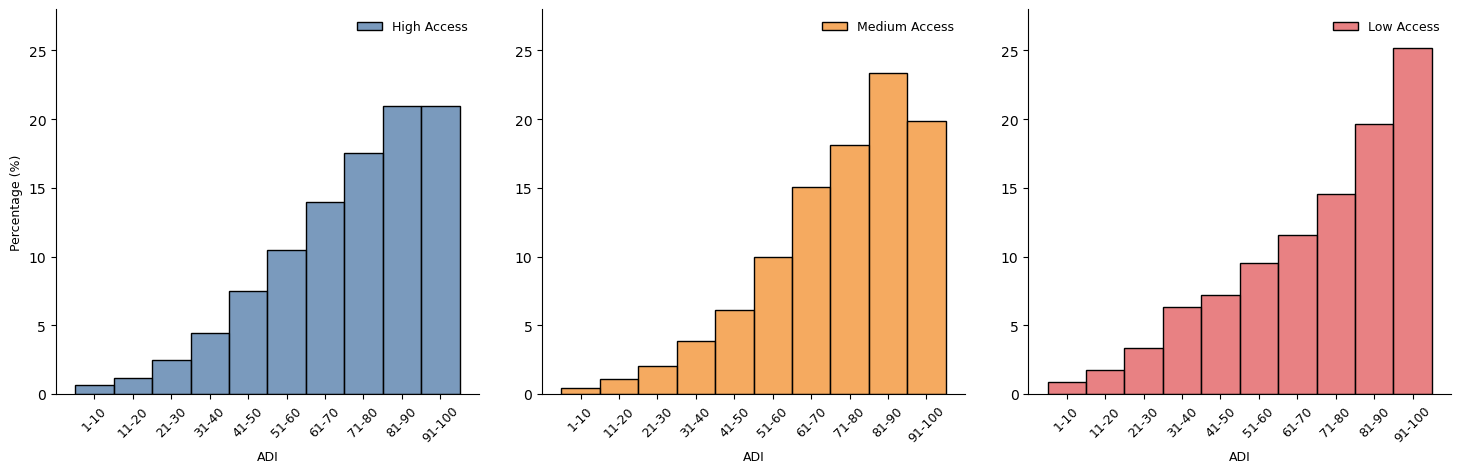

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.15)

bins = np.arange(0, 101, 10)
labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

font = {'family': 'sans-serif',
        'color': 'black',
        'weight': 'normal',
        'size': 9}

e = sns.histplot(ax=axes[0], data=rural_high_access.ADI_NATRANK, stat='percent', bins=bins, color='#4e79a7')
e.set_xticks((bins[:-1] + bins[1:]) / 2)
e.set_xticklabels(labels, fontdict=font, rotation=45)
e.set_ylim(0, 28)
e.set_xlabel('ADI', fontdict=font)
e.set_ylabel('Percentage (%)', fontdict=font)
e.legend(['High Access'], loc='upper right', prop={'size': 9, 'family': 'sans-serif'}, frameon = False)
e.spines['right'].set_visible(False)
e.spines['top'].set_visible(False)

d = sns.histplot(ax=axes[1], data=rural_medium_access.ADI_NATRANK, stat='percent', bins=bins, color='#f28e2b')
d.set_xticks((bins[:-1] + bins[1:]) / 2)
d.set_xticklabels(labels, fontdict=font, rotation=45)
d.set_ylim(0, 28)
d.set_xlabel('ADI', fontdict=font)
d.set_ylabel('', fontdict=font)
d.legend(['Medium Access'], loc='upper right', prop={'size': 9, 'family': 'sans-serif'}, frameon = False)
d.spines['right'].set_visible(False)
d.spines['top'].set_visible(False)

n = sns.histplot(ax=axes[2], data=rural_low_access.ADI_NATRANK, stat='percent', bins=bins, color='#e15759')
n.set_xticks((bins[:-1] + bins[1:]) / 2)
n.set_xticklabels(labels, fontdict=font, rotation=45)
n.set_ylim(0, 28)
n.set_xlabel('ADI', fontdict=font)
n.set_ylabel('', fontdict=font)
n.legend(['Low Access'], loc='upper right', prop={'size': 9, 'family': 'sans-serif'}, frameon = False)
n.spines['right'].set_visible(False)
n.spines['top'].set_visible(False)

plt.show()




# Figure 2 (Rural)

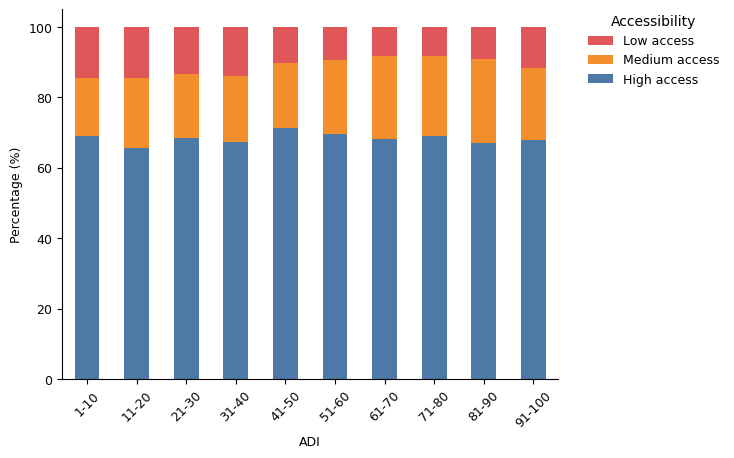

In [43]:
df_rural_all = pd.concat([
    pd.DataFrame({'accessibility': 'High access', 'ADI_NATRANK': rural_high_access.ADI_NATRANK}),
    pd.DataFrame({'accessibility': 'Medium access', 'ADI_NATRANK': rural_medium_access.ADI_NATRANK}),
    pd.DataFrame({'accessibility': 'Low access', 'ADI_NATRANK': rural_low_access.ADI_NATRANK})
])
#colors = {'Easy access': '#1f77b4', 'Difficult access': '#ff7f0e', 'No access': '#2ca02c'}
colors = {'High access': '#4e79a7', 'Medium access': '#f28e2b', 'Low access': '#e15759'}
bins = np.arange(0, 101, 10)
labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df_rural_all['binned'] = pd.cut(df_rural_all['ADI_NATRANK'], bins=bins, labels=labels, right=False)
grouped_rural = df_rural_all.groupby(['binned', 'accessibility']).size().unstack().fillna(0)

grouped_rural_percentage = grouped_rural.divide(grouped_rural.sum(axis=1), axis=0) * 100
grouped_rural_percentage = grouped_rural_percentage[['High access', 'Medium access', 'Low access']]
ax = grouped_rural_percentage.plot.bar( stacked=True, color=[colors[col] for col in grouped_rural_percentage.columns],rot=0)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 9,
        }

plt.xlabel('ADI', fontdict = font)
plt.ylabel('Percentage (%)', fontdict = font)
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]  # Order of legend items (High, Medium, Low)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title='Accessibility', prop={'size': 9, 'family': 'sans-serif'}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
#plt.legend(title='Accessibility', prop={'size': 9, 'family': 'sans-serif'}, bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad=0, frameon = False)
ax.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=45)
plt.show()



# Table 1 (a)

## (1) Characteristics of BGs in urban areas

In [44]:
print('1. total # BGs in urban area): ', len(df_metro))
print('--------------------------------------------')

print('2. Statistics of national ADI percentiles')
print('how many valid BGs: ', len(df_metro.loc[~df_metro.ADI_NATRANK.isna()]))
print('Mean: ', np.mean(df_metro.ADI_NATRANK))
print('SD: ', np.std(df_metro.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((df_metro.ADI_NATRANK)), 
                                   scale=st.sem((df_metro.ADI_NATRANK), nan_policy='omit')))
print('--------------------------------------------')

print('3. Statistic of travel time (accessibility)')
print('Mean: ', np.mean(df_metro.access))
print('SD: ', np.std(df_metro.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((df_metro.access)), 
                                   scale=st.sem((df_metro.access), nan_policy='omit')))

print('--------------------------------------------')

1. total # BGs in urban area):  198767
--------------------------------------------
2. Statistics of national ADI percentiles
how many valid BGs:  193841
Mean:  45.74869093741778
SD:  28.246099322757193
95% CI:  (45.6229476320332, 45.87443424280235)
--------------------------------------------
3. Statistic of travel time (accessibility)
Mean:  59.3023096630718
SD:  249.8452402457141
95% CI:  (58.20224062575211, 60.402378700391495)
--------------------------------------------


## (2) Level of Accessibility

Here's the definitions of "Easy, Difficult, or No accessibility" between a BG and its nearest food pantry by either public transit or walking. 

<div align="center">

| Transit 	| Walking 	| **High/Medium/Low?** 	|
|---------	|---------	|-------------------	|
| N     	| N       	| Low                	|
| N       	| <= 15   	| High              	|
| N       	| > 15 < 30 | Medium            	|
| <= 30   	| N       	| High              	|
| > 30 <=60 | N       	| Medium            	|
| <= 30   	| <= 15   	| High              	|
| <= 30   	| > 15    	| High              	|
| > 60    	| <= 15   	| High              	|
| > 30 <=60 | > 15 < 30 | Medium            	|
| > 60      | > 15 < 30 | Medium            	|
| > 30 <=60 | > 30      | Medium            	|
| > 60    	| > 30    	| Low                	|
| > 60    	| N    	    | Low                	|
| N    	    | > 30    	| Low                	|
</div>

### `high access` in Table 1 (a)

In [45]:
metro_high_access = pd.concat([df_metro.loc[(df_metro.transit_time.isna()) & (df_metro.walking_time <= 15)], 
                        df_metro.loc[(df_metro.transit_time <= 30) & (df_metro.walking_time.isna())], 
                        df_metro.loc[(df_metro.transit_time <= 30) & (df_metro.walking_time <= 15)], 
                        df_metro.loc[(df_metro.transit_time <= 30) & (df_metro.walking_time > 15)], 
                        df_metro.loc[(df_metro.transit_time > 30) & (df_metro.walking_time <= 15)]], ignore_index=True)

In [46]:
print('1. total # BGs in high access(urban): ', len(metro_high_access))
print('total % BGs in high access(urban): ', len(metro_high_access)/len(df_metro))
print('--------------------------------------------')

print('2. Statistics of national ADI percentiles')
print('how many valid BGs: ', len(metro_high_access.loc[~metro_high_access.ADI_NATRANK.isna()]))
print('Mean: ', np.mean(metro_high_access.ADI_NATRANK))
print('SD: ', np.std(metro_high_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((metro_high_access.ADI_NATRANK)), 
                                   scale=st.sem((metro_high_access.ADI_NATRANK), nan_policy='omit')))
print('--------------------------------------------')

print('3. Statistic of travel time (accessibility)')
print('Mean: ', np.mean(metro_high_access.access))
print('SD: ', np.std(metro_high_access.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((metro_high_access.access)), 
                                   scale=st.sem((metro_high_access.access), nan_policy='omit')))

print('--------------------------------------------')

1. total # BGs in high access(urban):  96285
total % BGs in high access(urban):  0.4844113962579301
--------------------------------------------
2. Statistics of national ADI percentiles
how many valid BGs:  93758
Mean:  48.49060346850402
SD:  30.2731027874591
95% CI:  (48.296826045857, 48.68438089115104)
--------------------------------------------
3. Statistic of travel time (accessibility)
Mean:  15.837274376417234
SD:  7.573961951989897
95% CI:  (15.789434048478665, 15.885114704355804)
--------------------------------------------


### `medium access` in Table 1 (a)

In [47]:
metro_medium_access = pd.concat([df_metro.loc[(df_metro.transit_time.isna()) & (df_metro.walking_time > 15) & (df_metro.walking_time <= 30)], 
                        df_metro.loc[(df_metro.transit_time > 30) & (df_metro.transit_time <= 60) & (df_metro.walking_time.isna())], 
                        df_metro.loc[(df_metro.transit_time > 30) & (df_metro.transit_time <= 60) & (df_metro.walking_time > 15)& (df_metro.walking_time <= 30) ],
                        df_metro.loc[(df_metro.walking_time > 15) & (df_metro.walking_time <= 30) & (df_metro.transit_time > 60)],
                        df_metro.loc[(df_metro.transit_time > 30) & (df_metro.transit_time <= 60) & (df_metro.walking_time > 30)]], ignore_index=True)

In [48]:
print('1. total # BGs in medium access(urban): ', len(metro_medium_access))
print('total % BGs in medium access(urban): ', len(metro_medium_access)/len(df_metro))
print('--------------------------------------------')

print('2. Statistics of national ADI percentiles')
print('how many valid BGs: ', len(metro_medium_access.loc[~metro_medium_access.ADI_NATRANK.isna()]))
print('Mean: ', np.mean(metro_medium_access.ADI_NATRANK))
print('SD: ', np.std(metro_medium_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((metro_medium_access.ADI_NATRANK)), 
                                   scale=st.sem((metro_medium_access.ADI_NATRANK), nan_policy='omit')))
print('--------------------------------------------')

print('3. Statistic of travel time (accessibility)')
print('Mean: ', np.mean(metro_medium_access.access))
print('SD: ', np.std(metro_medium_access.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((metro_medium_access.access)), 
                                   scale=st.sem((metro_medium_access.access), nan_policy='omit')))

print('--------------------------------------------')

1. total # BGs in medium access(urban):  50651
total % BGs in medium access(urban):  0.25482600230420543
--------------------------------------------
2. Statistics of national ADI percentiles
how many valid BGs:  49607
Mean:  41.72995746568024
SD:  26.611928544684734
95% CI:  (41.49577340341159, 41.9641415279489)
--------------------------------------------
3. Statistic of travel time (accessibility)
Mean:  42.57948839443775
SD:  8.518565572917296
95% CI:  (42.50530190217213, 42.65367488670338)
--------------------------------------------


### `low access` in Table 1 (a)

In [49]:
metro_low_access = pd.concat([df_metro.loc[(df_metro.transit_time.isna()) & (df_metro.walking_time.isna())],
                            df_metro.loc[(df_metro.transit_time > 60) & (df_metro.walking_time > 30)],
                            df_metro.loc[(df_metro.transit_time > 60) & (df_metro.walking_time.isna())],
                            df_metro.loc[(df_metro.walking_time > 30) & (df_metro.transit_time.isna())]], ignore_index=True)

In [50]:
print('1. total # BGs in low access(urban): ', len(metro_low_access))
print('total % BGs in low access(urban): ', len(metro_low_access)/len(df_metro))
print('--------------------------------------------')

print('2. Statistics of national ADI percentiles')
print('how many valid BGs: ', len(metro_low_access.loc[~metro_low_access.ADI_NATRANK.isna()]))
print('Mean: ', np.mean(metro_low_access.ADI_NATRANK))
print('SD: ', np.std(metro_low_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((metro_low_access.ADI_NATRANK)), 
                                   scale=st.sem((metro_low_access.ADI_NATRANK), nan_policy='omit')))
print('--------------------------------------------')

print('3. Statistic of travel time (accessibility)')
print('Mean: ', np.mean(metro_low_access.access))
print('SD: ', np.std(metro_low_access.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((metro_low_access.access)), 
                                   scale=st.sem((metro_low_access.access), nan_policy='omit')))

print('--------------------------------------------')

1. total # BGs in low access(urban):  51831
total % BGs in low access(urban):  0.26076260143786445
--------------------------------------------
2. Statistics of national ADI percentiles
how many valid BGs:  50476
Mean:  44.60519851018306
SD:  25.188695281730023
95% CI:  (44.38545523166135, 44.82494178870476)
--------------------------------------------
3. Statistic of travel time (accessibility)
Mean:  157.5520810798498
SD:  477.33177844765584
95% CI:  (153.41812735195037, 161.68603480774925)
--------------------------------------------


# Figure 1 (a)

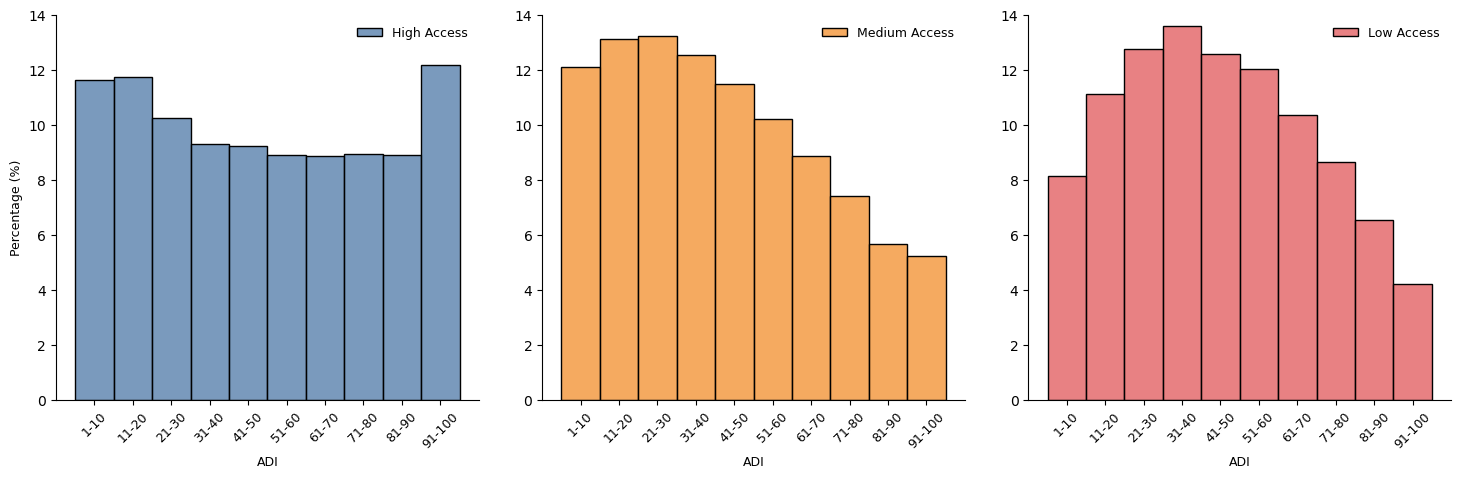

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.15)

bins = np.arange(0, 101, 10)
labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

font = {'family': 'sans-serif',
        'color': 'black',
        'weight': 'normal',
        'size': 9}

e = sns.histplot(ax=axes[0], data=metro_high_access.ADI_NATRANK, stat='percent', bins=bins, color='#4e79a7')
e.set_xticks((bins[:-1] + bins[1:]) / 2)
e.set_xticklabels(labels, fontdict=font, rotation=45)
e.set_ylim(0, 14)
e.set_xlabel('ADI', fontdict=font)
e.set_ylabel('Percentage (%)', fontdict=font)
e.legend(['High Access'], loc='upper right', prop={'size': 9, 'family': 'sans-serif'}, frameon = False)
e.spines['right'].set_visible(False)
e.spines['top'].set_visible(False)

d = sns.histplot(ax=axes[1], data=metro_medium_access.ADI_NATRANK, stat='percent', bins=bins, color='#f28e2b')
d.set_xticks((bins[:-1] + bins[1:]) / 2)
d.set_xticklabels(labels, fontdict=font, rotation=45)
d.set_ylim(0, 14)
d.set_xlabel('ADI', fontdict=font)
d.set_ylabel('', fontdict=font)
d.legend(['Medium Access'], loc='upper right', prop={'size': 9, 'family': 'sans-serif'}, frameon = False)
d.spines['right'].set_visible(False)
d.spines['top'].set_visible(False)

n = sns.histplot(ax=axes[2], data=metro_low_access.ADI_NATRANK, stat='percent', bins=bins, color='#e15759')
n.set_xticks((bins[:-1] + bins[1:]) / 2)
n.set_xticklabels(labels, fontdict=font, rotation=45)
n.set_ylim(0, 14)
n.set_xlabel('ADI', fontdict=font)
n.set_ylabel('', fontdict=font)
n.legend(['Low Access'], loc='upper right', prop={'size': 9, 'family': 'sans-serif'}, frameon = False)
n.spines['right'].set_visible(False)
n.spines['top'].set_visible(False)

plt.show()





# Figure 2 (urban)

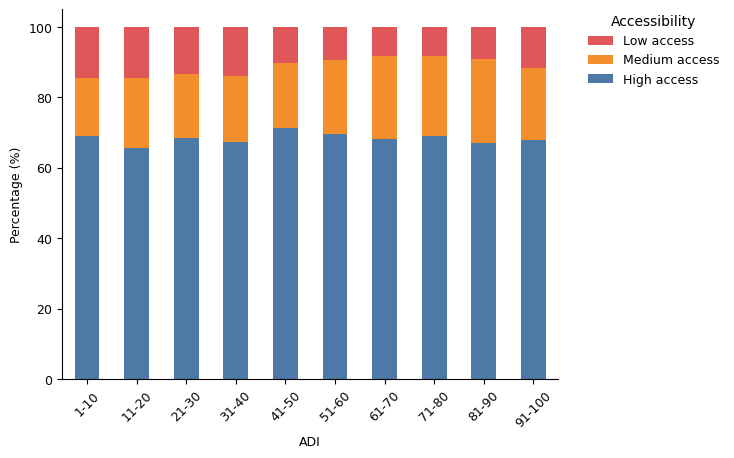

In [52]:
df_metro_all = pd.concat([
    pd.DataFrame({'accessibility': 'High access', 'ADI_NATRANK': metro_high_access.ADI_NATRANK}),
    pd.DataFrame({'accessibility': 'Medium access', 'ADI_NATRANK': metro_medium_access.ADI_NATRANK}),
    pd.DataFrame({'accessibility': 'Low access', 'ADI_NATRANK': metro_low_access.ADI_NATRANK})
])

bins = np.arange(0, 101, 10)
labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df_metro_all['binned'] = pd.cut(df_metro_all['ADI_NATRANK'], bins=bins, labels=labels, right=False)
colors = {'High access': '#4e79a7', 'Medium access': '#f28e2b', 'Low access': '#e15759'}
grouped_metro = df_metro_all.groupby(['binned', 'accessibility']).size().unstack().fillna(0)

grouped_metro_percentage = grouped_metro.divide(grouped_metro.sum(axis=1), axis=0) * 100
grouped_metro_percentage = grouped_rural_percentage[['High access', 'Medium access', 'Low access']]
ax = grouped_metro_percentage.plot.bar( stacked=True, color=[colors[col] for col in grouped_metro_percentage.columns],rot=0)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 9,
        }
plt.xlabel('ADI', fontdict = font)
plt.ylabel('Percentage (%)', fontdict = font)
#plt.legend(title='Accessibility', prop={'size': 9, 'family': 'sans-serif'})
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]  # Order of legend items (High, Medium, Low)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title='Accessibility', prop={'size': 9, 'family': 'sans-serif'}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
#plt.legend(title='Accessibility', prop={'size': 9, 'family': 'sans-serif'}, bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad=0, frameon = False)
ax.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=45)
plt.show()




In [53]:
rural_county_fips = df_rural_dist.groupby(['bg_county']).category.value_counts(normalize=True).unstack().idxmax(axis=1).to_frame().index.tolist()
rural_access_type_county = df_rural_dist.groupby(['bg_county']).category.value_counts(normalize=True).unstack().idxmax(axis=1).to_frame().unstack().tolist()

rural_access_type_county_df = pd.DataFrame(list(zip(rural_county_fips, rural_access_type_county)), columns =['county_fips', 'type_of_accessibility'])
rural_access_type_county_df['county_state'] = rural_access_type_county_df.progress_apply(lambda x:find_state_fips(x.county_fips, state_fips), axis=1)

100%|████████████████████████████████████| 1977/1977 [00:00<00:00, 22414.70it/s]


In [54]:
rural_access_type_county_df.to_csv('../data/rural_access_type_county_df.csv', index=False)

In [55]:
metro_high_access['category'] = 'High access'
metro_medium_access['category'] = 'Medium access'
metro_low_access['category'] = 'Low access'

metro_bg_access = pd.concat([metro_high_access, metro_medium_access, metro_low_access]).reset_index(drop=True)

In [56]:
metro_county_fips = metro_bg_access.groupby(['bg_county']).category.value_counts(normalize=True).unstack().idxmax(axis=1).to_frame().index.tolist()
metro_access_type_county = metro_bg_access.groupby(['bg_county']).category.value_counts(normalize=True).unstack().idxmax(axis=1).to_frame().unstack().tolist()

metro_access_type_county_df = pd.DataFrame(list(zip(metro_county_fips, metro_access_type_county)), columns =['county_fips', 'type_of_accessibility'])
metro_access_type_county_df['county_state'] = metro_access_type_county_df.progress_apply(lambda x:find_state_fips(x.county_fips, state_fips), axis=1)

100%|████████████████████████████████████| 1166/1166 [00:00<00:00, 23603.20it/s]


In [57]:
metro_access_type_county_df.to_csv('../data/metro_access_type_county_df.csv', index=False)

In [58]:
metro_category_counts_per_state = metro_bg_access.groupby('bg_state')['category'].value_counts().unstack().fillna(0)

metro_category_counts_per_state['total'] = metro_category_counts_per_state.sum(axis=1)

metro_category_counts_per_state['high_proportion'] = metro_category_counts_per_state['High access'] / metro_category_counts_per_state['total']
metro_category_counts_per_state['medium_proportion'] = metro_category_counts_per_state['Medium access'] / metro_category_counts_per_state['total']
metro_category_counts_per_state['low_proportion'] = metro_category_counts_per_state['Low access'] / metro_category_counts_per_state['total']
metro_category_counts_per_state=metro_category_counts_per_state.reset_index()
print(metro_category_counts_per_state)

category bg_state  High access  Low access  Medium access  total  \
0              AK          157          90             77    324   
1              AL          982        1285            634   2901   
2              AR          545         469            305   1319   
3              AZ         1978        1309           1191   4478   
4              CA        11798        3926           9142  24866   
5              CO         1750         761            944   3455   
6              CT         1352         479            705   2536   
7              DC          514          14             43    571   
8              DE          287         216            203    706   
9              FL         5329        3590           3911  12830   
10             GA         1917        2541           1505   5963   
11             HI          544         129            210    883   
12             IA          693         393            328   1414   
13             ID          326         209      

In [59]:
metro_category_counts_per_state.to_csv('../data/metro_category_counts_per_state.csv', index=False)

In [60]:
rural_category_counts_per_state = df_rural_dist.groupby('bg_state')['category'].value_counts().unstack().fillna(0)

rural_category_counts_per_state['total'] = rural_category_counts_per_state.sum(axis=1)

rural_category_counts_per_state['high_proportion'] = rural_category_counts_per_state['High access'] / rural_category_counts_per_state['total']
rural_category_counts_per_state['medium_proportion'] = rural_category_counts_per_state['Medium access'] / rural_category_counts_per_state['total']
rural_category_counts_per_state['low_proportion'] = rural_category_counts_per_state['Low access'] / rural_category_counts_per_state['total']
rural_category_counts_per_state = rural_category_counts_per_state.reset_index()
print(rural_category_counts_per_state)

category bg_state  High access  Low access  Medium access  total  \
0              AK           72          98             10    180   
1              AL          618         119            287   1024   
2              AR          693          68            214    975   
3              AZ          143         121             31    295   
4              CA          373         238            130    741   
5              CO          376         124            103    603   
6              CT          175           1              4    180   
7              FL          359          55            144    558   
8              GA          996         134            353   1483   
9              HI          144          32             24    200   
10             IA          854          79            356   1289   
11             ID          326          67             93    486   
12             IL         1199          37            300   1536   
13             IN         1120           6      

In [61]:
rural_category_counts_per_state.to_csv('../data/rural_category_counts_per_state.csv', index=False)

In [62]:
county_bg_access_all = pd.concat([metro_access_type_county_df, rural_access_type_county_df]).reset_index(drop=True)
county_bg_access_all.to_csv('../data/access_type_county_all.csv', index=False)

In [63]:
rural_mean_ADI_per_state = df_rural_dist.groupby('bg_state')['ADI_NATRANK'].mean().reset_index()
rural_mean_ADI_per_state.to_csv('../data/rural_mean_ADI_per_state_test.csv',index=False)

In [64]:
metro_mean_ADI_per_state = df_metro.groupby('bg_state')['ADI_NATRANK'].mean().reset_index()
metro_mean_ADI_per_state.to_csv('../data/metro_mean_ADI_per_state_test.csv',index=False)

In [65]:
rural_mean_ADI_per_state_category = df_rural_dist.groupby(['bg_state', 'category'])['ADI_NATRANK'].mean().reset_index()
#print(rural_mean_ADI_per_state_category)
pivot_rural_mean_ADI = rural_mean_ADI_per_state_category.pivot(index='bg_state', columns='category', values='ADI_NATRANK').reset_index()

pivot_rural_mean_ADI.to_csv('../data/rural_mean_ADI_per_state_category_pivot.csv', index=False)
#print(pivot_rural_mean_ADI)

In [66]:
metro_mean_ADI_per_state_category = metro_bg_access.groupby(['bg_state', 'category'])['ADI_NATRANK'].mean().reset_index()
#print(rural_mean_ADI_per_state_category)
pivot_metro_mean_ADI = metro_mean_ADI_per_state_category.pivot(index='bg_state', columns='category', values='ADI_NATRANK').reset_index()

pivot_metro_mean_ADI.to_csv('../data/metro_mean_ADI_per_state_category_pivot.csv', index=False)
#print(pivot_rural_mean_ADI)

Prepare the files for regression analysis

In [67]:
df_rural_dist.to_csv('../data/rural_fp_regression.csv',index=False)
metro_bg_access.to_csv('../data/metro_fp_regression.csv',index=False)

In [68]:
bg_access_all = pd.concat([metro_bg_access, df_rural_dist]).reset_index(drop=True)
county_bg_access_all.to_csv('../data/bg_fp_regression.csv', index=False)